# I - Cleaning database : 
Check Image formats and delete bad formats 

##### 1- create a function that checks the format of the img files in a specific doc  

- Function list_bad_format : takes a the directory of images contained in classnames folders  

In [1]:
import os
import imghdr


def list_bad_format(directory,accepted_formats=['jpeg','png','jpg']):
    classnames = [f for f in os.listdir(directory) if not os.path.isfile(directory+'/'+f)]

    bad_format=[]
    for classname in classnames :
        filenames = os.listdir(directory+'/'+classname)
        for filename in filenames :
            if filename[-4:] in accepted_formats or filename[-3:] in accepted_formats :
                filename=directory+'/'+classname+'/'+filename
                format = imghdr.what(filename) #Check format
                if not format in accepted_formats:
                    bad_format.append((filename,format))
    return bad_format


######   ----test unitaire - list_bad_format---

In [2]:
directory = 'datasets/dataset-test-bad-format'
accepted_formats=['jpeg','png']

bad_format_test=list_bad_format(directory)
bad_format_test 

# Result :
# [('datasets/dataset-test-bad-format/Cattail/Cattail2.jpg', 'webp'),
#  ('datasets/dataset-test-bad-format/Cattail/Cattail49.jpg', None)]

[('datasets/dataset-test-bad-format/Cattail/Cattail2.jpg', 'webp'),
 ('datasets/dataset-test-bad-format/Cattail/Cattail49.jpg', None)]

------------------

- Application sur notre dataset

In [3]:
directory_train = 'datasets/dataset'
directory_test = 'datasets/dataset-test'
accepted_formats=['jpeg','png','jpg']

In [4]:
bad_format_train=list_bad_format(directory_train)
bad_format_test=list_bad_format(directory_test)

In [5]:
len(bad_format_train)

25

##### 2- create a function that counts the number of images with a bad format  

- Function count_groups : takes a list of tupples and the position in the tuple of the key to group by -- retun an interator with az tuple containing a key and number of occurences 

In [6]:
import itertools
import operator

def count_groups(list_tupples,position):
     list_tupples = sorted(list_tupples, key=operator.itemgetter(position))
     it = itertools.groupby(list_tupples, operator.itemgetter(position))
     for key, subiter in it:
          yield key, len(list(subiter))

In [7]:
#Test unitaire de la fonction
L = [('grape', 100), ('apple', 15), ('apple', 10), ('grape', 3),
     ('apple', 4), ('banana', 3)]

L_inverse = [(l[1],l[0]) for l in L]

print(list(count_groups(L,0)))
print(list(count_groups(L_inverse,1)))

#Result :
# [('apple', 3), ('banana', 1), ('grape', 2)]
# [('apple', 3), ('banana', 1), ('grape', 2)]

[('apple', 3), ('banana', 1), ('grape', 2)]
[('apple', 3), ('banana', 1), ('grape', 2)]


--------------

- Application sur notre dataset

In [8]:
bad_format_train=[(tpl[0],'None') if tpl[1] is None else tpl for tpl in bad_format_train]
bad_format_test=[(tpl[0],'None') if tpl[1] is None else tpl for tpl in bad_format_test]
list(count_groups(bad_format_train,1))
list(count_groups(bad_format_test,1))

[('None', 3)]

##### 3- After verification of the bad formats, deleting those images  

- Function delete_file : takes a file directory and delete it 

In [9]:
import os

def delete_file(file_directory):
    if os.path.isfile(file_directory) :
        os.remove(file_directory)
        return 1
    else :
        return 0

######   ----test unitaire - delete_file ---

In [10]:
f = open("test_uni.txt", "a")
f.close()

print(delete_file("test_uni.txt"))

#Result:
#1

1


--------------------------

- Application sur notre dataset

In [11]:
# for train directory
for file_directory,_ in bad_format_train:
    delete_file(file_directory)

bad_format_train=list_bad_format(directory_train)

# for test directory
for file_directory,_ in bad_format_test:
    delete_file(file_directory)

bad_format_test=list_bad_format(directory_test)

In [13]:
bad_format_train

[]

# II - Import of the training dataset : 

##### 1- Create an image Generator

In [15]:
import tensorflow as tf

img_generator = tf.keras.preprocessing.image.ImageDataGenerator(#rotation_range=90,
                                                                #brightness_range=(0.5,1), 
                                                                #shear_range=0.2, 
                                                                #zoom_range=0.2,
                                                                #channel_shift_range=0.2,
                                                                fill_mode = 'reflect',
                                                                horizontal_flip=True,
                                                                vertical_flip=True,
                                                                rescale=1./255,
                                                                validation_split=0.3)

##### 1- Generating images

In [16]:
img_generator_flow_train = img_generator.flow_from_directory(
    directory=directory_train,
    target_size=(299, 299),
    batch_size=16,
    shuffle=True
    #subset="training"
    )

img_generator_flow_test = img_generator.flow_from_directory(
    directory=directory_test,
    target_size=(299, 299),
    batch_size=16,
    shuffle=True
    #subset="validation"
    )

Found 6533 images belonging to 62 classes.
Found 307 images belonging to 62 classes.


C:\Users\Youness\AppData\Local\Temp/ipykernel_37776/2148456837.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


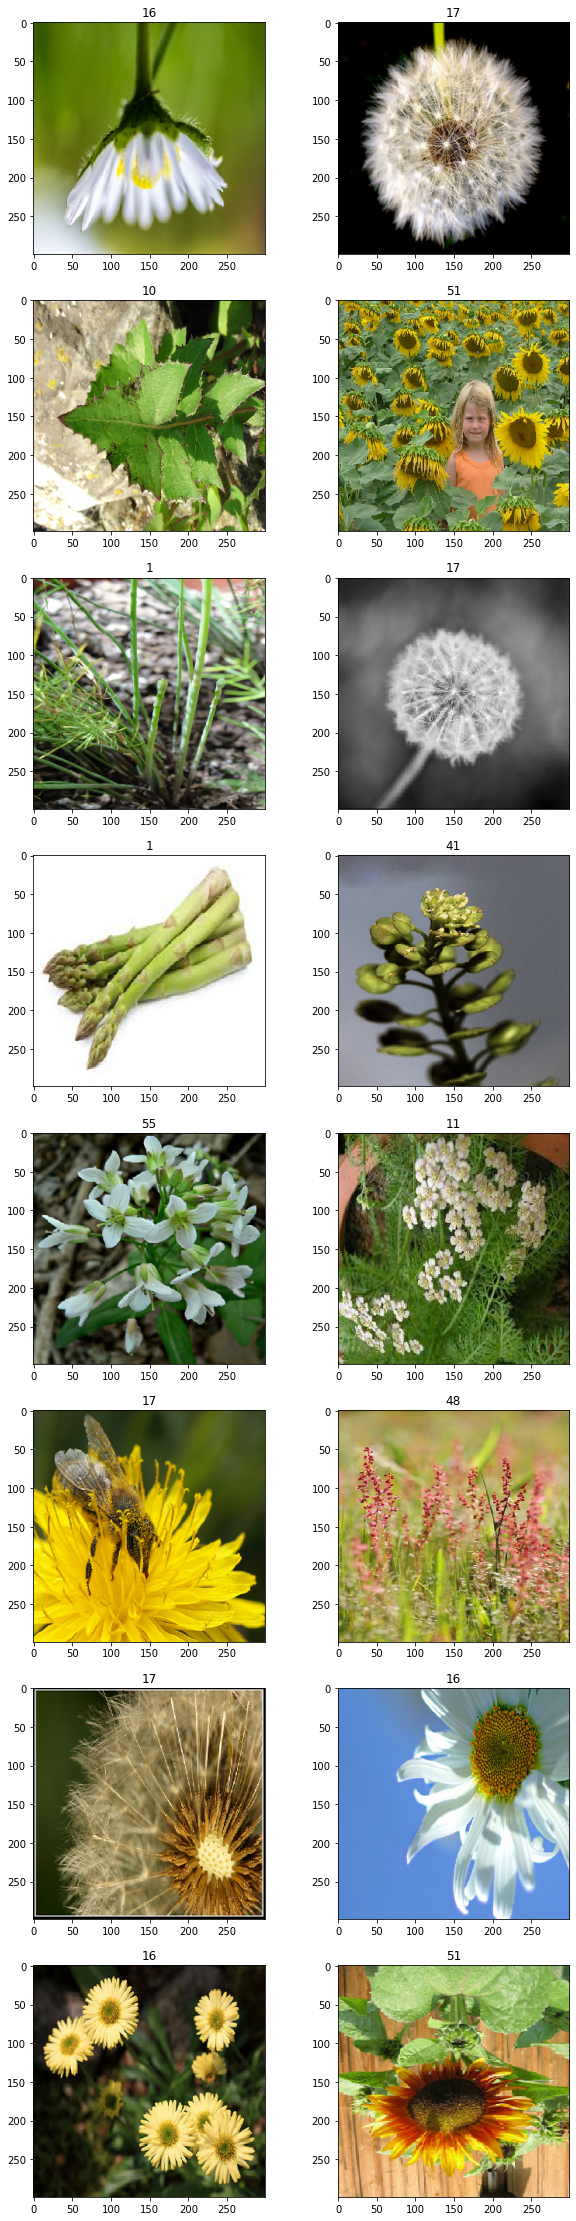

In [17]:
import matplotlib.pyplot as plt 
import numpy as np

imgs, targets = next(iter(img_generator_flow_train))
fig, ax = plt.subplots(8,2, figsize=(10,40))
for i, (img, target) in enumerate(zip(imgs, targets)):
  ax[i-8*(i//8),i//8].imshow(img)
  ax[i-8*(i//8),i//8].title.set_text(str(np.argmax(target)))
fig.show()

In [18]:
num_classes=img_generator_flow_train.num_classes

In [19]:
# Let's create a learning rate schedule to decrease the learning rate as we train the model. 
initial_learning_rate = 0.001

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.96,
    staircase=True)

In [35]:
len(img_generator_flow_train.labels==2)

6533

In [36]:
#let's set weights :

labels=img_generator_flow_train.labels
nb_imgs = len(labels)

weights=dict()
for i in range(num_classes):
    nb_img_i=sum(labels==i)
    weights[i]=nb_imgs/nb_img_i/5


# Modele 1

In [65]:
img_generator_flow_train = img_generator.flow_from_directory(
    directory=directory_train,
    target_size=(224, 224),
    batch_size=128,
    shuffle=True
    #subset="training"
    )

img_generator_flow_test = img_generator.flow_from_directory(
    directory=directory_test,
    target_size=(224, 224),
    batch_size=128,
    shuffle=True
    #subset="validation"
    )

Found 6533 images belonging to 62 classes.
Found 307 images belonging to 62 classes.


In [46]:
base_model = tf.keras.applications.MobileNet(input_shape=(224,224,3), 
                                               include_top=False,
                                               weights = "imagenet"
                                               )

base_model.trainable = False

In [47]:
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalMaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(num_classes, activation="softmax")
])

In [48]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = lr_schedule),
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics = [tf.keras.metrics.CategoricalAccuracy()])

In [49]:
model.fit(img_generator_flow_train, validation_data=img_generator_flow_test, epochs=30,class_weight=weights)

Epoch 1/30
52/52 [==============================] - 26s 445ms/step - loss: 82.9341 - categorical_accuracy: 0.1010 - val_loss: 4.8039 - val_categorical_accuracy: 0.1629
Epoch 2/30
52/52 [==============================] - 23s 439ms/step - loss: 45.7622 - categorical_accuracy: 0.3159 - val_loss: 4.0949 - val_categorical_accuracy: 0.2704
Epoch 3/30
52/52 [==============================] - 23s 447ms/step - loss: 33.4302 - categorical_accuracy: 0.4369 - val_loss: 3.4367 - val_categorical_accuracy: 0.3681
Epoch 4/30
52/52 [==============================] - 23s 444ms/step - loss: 26.8026 - categorical_accuracy: 0.5188 - val_loss: 3.3027 - val_categorical_accuracy: 0.3485
Epoch 5/30
52/52 [==============================] - 23s 445ms/step - loss: 23.3371 - categorical_accuracy: 0.5484 - val_loss: 3.4814 - val_categorical_accuracy: 0.3909
Epoch 6/30
52/52 [==============================] - 23s 440ms/step - loss: 19.0013 - categorical_accuracy: 0.6172 - val_loss: 2.7997 - val_categorical_accuracy:

# Modele 2

In [50]:
img_generator_flow_train.image_shape

(224, 224, 3)

In [51]:
import tensorflow_hub as hub
m = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/inaturalist/inception_v3/feature_vector/4",
                   trainable=False),  # Can be True, see below.
    tf.keras.layers.Dense(num_classes, activation='softmax')
])
m.build([None, 224, 224, 3])

In [52]:
m.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 2048)              21802784  
                                                                 
 dense_3 (Dense)             (None, 62)                127038    
                                                                 
Total params: 21,929,822
Trainable params: 127,038
Non-trainable params: 21,802,784
_________________________________________________________________


In [53]:
m.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = lr_schedule),
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics = [tf.keras.metrics.CategoricalAccuracy()])

In [54]:
m.fit(img_generator_flow_train, validation_data=img_generator_flow_test, epochs=30,class_weight=weights)

Epoch 1/30
52/52 [==============================] - 33s 450ms/step - loss: 23.9702 - categorical_accuracy: 0.6042 - val_loss: 0.7640 - val_categorical_accuracy: 0.8176
Epoch 2/30
52/52 [==============================] - 23s 444ms/step - loss: 7.1362 - categorical_accuracy: 0.8550 - val_loss: 0.6382 - val_categorical_accuracy: 0.8306
Epoch 3/30
52/52 [==============================] - 23s 443ms/step - loss: 4.9870 - categorical_accuracy: 0.8846 - val_loss: 0.6447 - val_categorical_accuracy: 0.8436
Epoch 4/30
52/52 [==============================] - 23s 444ms/step - loss: 3.8447 - categorical_accuracy: 0.9056 - val_loss: 0.5945 - val_categorical_accuracy: 0.8502
Epoch 5/30
52/52 [==============================] - 23s 445ms/step - loss: 3.2073 - categorical_accuracy: 0.9154 - val_loss: 0.5551 - val_categorical_accuracy: 0.8632
Epoch 6/30
52/52 [==============================] - 23s 444ms/step - loss: 2.5439 - categorical_accuracy: 0.9314 - val_loss: 0.6075 - val_categorical_accuracy: 0.85

# Modele 2bis

In [67]:
import tensorflow_hub as hub
rate = 0.1

m_bis = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/inaturalist/inception_v3/feature_vector/4",
                   trainable=False),  # Can be True, see below.
    tf.keras.layers.Dense(num_classes*2, activation ='relu'),
    tf.keras.layers.Dropout(rate),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])
m_bis.build([None, 224, 224, 3])

In [76]:
m_bis.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_4 (KerasLayer)  (None, 2048)              21802784  
                                                                 
 dense_9 (Dense)             (None, 124)               254076    
                                                                 
 dropout (Dropout)           (None, 124)               0         
                                                                 
 dense_10 (Dense)            (None, 62)                7750      
                                                                 
Total params: 22,064,610
Trainable params: 261,826
Non-trainable params: 21,802,784
_________________________________________________________________


In [68]:
m_bis.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = lr_schedule),
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics = [tf.keras.metrics.CategoricalAccuracy()])

In [69]:
m_bis.fit(img_generator_flow_train, validation_data=img_generator_flow_test, epochs=30,class_weight=weights)

Epoch 1/30
52/52 [==============================] - 40s 655ms/step - loss: 28.5920 - categorical_accuracy: 0.4839 - val_loss: 0.9523 - val_categorical_accuracy: 0.7720
Epoch 2/30
52/52 [==============================] - 24s 469ms/step - loss: 9.9071 - categorical_accuracy: 0.7866 - val_loss: 0.6744 - val_categorical_accuracy: 0.8306
Epoch 3/30
52/52 [==============================] - 24s 467ms/step - loss: 7.3898 - categorical_accuracy: 0.8157 - val_loss: 0.6378 - val_categorical_accuracy: 0.8274
Epoch 4/30
52/52 [==============================] - 25s 472ms/step - loss: 5.6790 - categorical_accuracy: 0.8494 - val_loss: 0.6073 - val_categorical_accuracy: 0.8469
Epoch 5/30
52/52 [==============================] - 24s 462ms/step - loss: 4.8692 - categorical_accuracy: 0.8635 - val_loss: 0.6671 - val_categorical_accuracy: 0.8111
Epoch 6/30
52/52 [==============================] - 25s 477ms/step - loss: 4.0826 - categorical_accuracy: 0.8786 - val_loss: 0.6891 - val_categorical_accuracy: 0.82

# Modele 3

In [55]:
m3 = tf.keras.Sequential([
    hub.KerasLayer('https://tfhub.dev/google/aiy/vision/classifier/plants_V1/1'),  # Can be True, see below.
    tf.keras.layers.Dense(num_classes, activation='softmax')
])
m3.build([None, 224, 224, 3])

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [56]:
m3.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 2102)              0         
                                                                 
 dense_4 (Dense)             (None, 62)                130386    
                                                                 
Total params: 130,386
Trainable params: 130,386
Non-trainable params: 0
_________________________________________________________________


In [57]:
m3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = lr_schedule),
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics = [tf.keras.metrics.CategoricalAccuracy()])

In [58]:
m3.fit(img_generator_flow_train, validation_data=img_generator_flow_test, epochs=60,class_weight=weights)

Epoch 1/60
52/52 [==============================] - 28s 487ms/step - loss: 50.9025 - categorical_accuracy: 0.2777 - val_loss: 4.0820 - val_categorical_accuracy: 0.4593
Epoch 2/60
52/52 [==============================] - 24s 460ms/step - loss: 50.3932 - categorical_accuracy: 0.6989 - val_loss: 4.0396 - val_categorical_accuracy: 0.7134
Epoch 3/60
52/52 [==============================] - 24s 460ms/step - loss: 49.8944 - categorical_accuracy: 0.7937 - val_loss: 4.0025 - val_categorical_accuracy: 0.7557
Epoch 4/60
52/52 [==============================] - 24s 456ms/step - loss: 49.4149 - categorical_accuracy: 0.8209 - val_loss: 3.9607 - val_categorical_accuracy: 0.8013
Epoch 5/60
52/52 [==============================] - 24s 458ms/step - loss: 48.9299 - categorical_accuracy: 0.8281 - val_loss: 3.9227 - val_categorical_accuracy: 0.7915
Epoch 6/60
52/52 [==============================] - 24s 463ms/step - loss: 48.4455 - categorical_accuracy: 0.8309 - val_loss: 3.8816 - val_categorical_accuracy:

# Modèle 4

In [59]:
img_generator_flow_train = img_generator.flow_from_directory(
    directory=directory_train,
    target_size=(299, 299),
    batch_size=128,
    shuffle=True
    #subset="training"
    )

img_generator_flow_test = img_generator.flow_from_directory(
    directory=directory_test,
    target_size=(299, 299),
    batch_size=128,
    shuffle=True
    #subset="validation"
    )

Found 6533 images belonging to 62 classes.
Found 307 images belonging to 62 classes.


In [63]:
m4= tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/inaturalist/vision/embedder/inaturalist_V2/1"),  # Can be True, see below.
    tf.keras.layers.Dense(num_classes*2, activation ='relu'),
    #tf.keras.layers.drop
    tf.keras.layers.Dense(num_classes, activation='softmax')
])
m4.build([None, 299, 299, 3])

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [75]:
m4.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_3 (KerasLayer)  (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 124)               8060      
                                                                 
 dense_8 (Dense)             (None, 62)                7750      
                                                                 
Total params: 15,810
Trainable params: 15,810
Non-trainable params: 0
_________________________________________________________________


15810

In [64]:
m4.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = lr_schedule),
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics = [tf.keras.metrics.CategoricalAccuracy()])

m4.fit(img_generator_flow_train, validation_data=img_generator_flow_test, epochs=30,class_weight=weights)

Epoch 1/30
52/52 [==============================] - 47s 726ms/step - loss: 49.5164 - categorical_accuracy: 0.2469 - val_loss: 3.8285 - val_categorical_accuracy: 0.5505
Epoch 2/30
52/52 [==============================] - 73s 1s/step - loss: 44.2920 - categorical_accuracy: 0.6879 - val_loss: 3.2473 - val_categorical_accuracy: 0.7752
Epoch 3/30
52/52 [==============================] - 32s 609ms/step - loss: 35.7612 - categorical_accuracy: 0.7807 - val_loss: 2.4750 - val_categorical_accuracy: 0.7850
Epoch 4/30
52/52 [==============================] - 31s 591ms/step - loss: 26.1791 - categorical_accuracy: 0.8134 - val_loss: 1.7389 - val_categorical_accuracy: 0.8208
Epoch 5/30
52/52 [==============================] - 41s 789ms/step - loss: 18.7573 - categorical_accuracy: 0.8264 - val_loss: 1.2712 - val_categorical_accuracy: 0.8371
Epoch 6/30
52/52 [==============================] - 32s 595ms/step - loss: 14.0128 - categorical_accuracy: 0.8361 - val_loss: 1.0140 - val_categorical_accuracy: 0.

# Last : Saving Models

In [37]:
import json

1- Model 1 : MobilNet

In [38]:
model.save("models/MobilNet_224_224.h5")
history_dict = model.history.history
# Save it under the form of a json file
json.dump(history_dict, open("models/MobilNet_244_244.json", 'w'))

2- Model 2 : Inception V3

In [40]:
m.save("models/InceptionV3_INat_224_224.h5")
history_dict = m.history.history
# Save it under the form of a json file
json.dump(history_dict, open("models/InceptionV3_INat_244_244.json", 'w'))

3- Model 3 : Vision-PlantV1

In [41]:
m3.save("models/PlantV1_INat_224_224.h5")
history_dict = m3.history.history
# Save it under the form of a json file
json.dump(history_dict, open("models/PlantV1_INat_244_244.json", 'w'))

4- Model 4 : Embeder-64 INat

In [42]:
m4.save("models/Embeder_INat_299_299.h5")
history_dict = m4.history.history
# Save it under the form of a json file
json.dump(history_dict, open("models/Embeder_INat_299_299.json", 'w'))

# Bonus : Display the evolution of the loss and the validation loss for choosing model

In [70]:
from plotly import graph_objects as go
color_chart = ["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]

history = model.history
fig = go.Figure(data=[
                      go.Scatter(
                          y=history.history["loss"],
                          name="Training loss",
                          mode="lines",
                          marker=dict(
                              color=color_chart[0]
                          )),
                      go.Scatter(
                          y=history.history["val_loss"],
                          name="Validation loss",
                          mode="lines",
                          marker=dict(
                              color=color_chart[1]
                          ))
])
fig.update_layout(
    title='Training and val loss across epochs : MobilNet',
    xaxis_title='epochs',
    yaxis_title='Cross Entropy'    
)
fig.show()

In [71]:

history = m.history
fig = go.Figure(data=[
                      go.Scatter(
                          y=history.history["loss"],
                          name="Training loss",
                          mode="lines",
                          marker=dict(
                              color=color_chart[0]
                          )),
                      go.Scatter(
                          y=history.history["val_loss"],
                          name="Validation loss",
                          mode="lines",
                          marker=dict(
                              color=color_chart[1]
                          ))
])
fig.update_layout(
    title='Training and val loss across epochs : InceptionV3 INat 2017',
    xaxis_title='epochs',
    yaxis_title='Cross Entropy'    
)
fig.show()

In [72]:
history = m_bis.history
fig = go.Figure(data=[
                      go.Scatter(
                          y=history.history["loss"],
                          name="Training loss",
                          mode="lines",
                          marker=dict(
                              color=color_chart[0]
                          )),
                      go.Scatter(
                          y=history.history["val_loss"],
                          name="Validation loss",
                          mode="lines",
                          marker=dict(
                              color=color_chart[1]
                          ))
])
fig.update_layout(
    title='Training and val loss across epochs : InceptionV3 INat 2017 with drop_out',
    xaxis_title='epochs',
    yaxis_title='Cross Entropy'    
)
fig.show()

In [73]:

history = m3.history
fig = go.Figure(data=[
                      go.Scatter(
                          y=history.history["loss"],
                          name="Training loss",
                          mode="lines",
                          marker=dict(
                              color=color_chart[0]
                          )),
                      go.Scatter(
                          y=history.history["val_loss"],
                          name="Validation loss",
                          mode="lines",
                          marker=dict(
                              color=color_chart[1]
                          ))
])
fig.update_layout(
    title='Training and val loss across epochs : Vision Plant V1',
    xaxis_title='epochs',
    yaxis_title='Cross Entropy'    
)
fig.show()

In [56]:
m3_history = history

In [74]:

history = m4.history
fig = go.Figure(data=[
                      go.Scatter(
                          y=history.history["loss"],
                          name="Training loss",
                          mode="lines",
                          marker=dict(
                              color=color_chart[0]
                          )),
                      go.Scatter(
                          y=history.history["val_loss"],
                          name="Validation loss",
                          mode="lines",
                          marker=dict(
                              color=color_chart[1]
                          ))
])
fig.update_layout(
    title='Training and val loss across epochs : Embeder-64 INat2018',
    xaxis_title='epochs',
    yaxis_title='Cross Entropy'    
)
fig.show()

0.9530736804008484

In [84]:
import mlflow
import mlflow.keras
import mlflow.pyfunc
from mlflow.pyfunc import PythonModel
from mlflow.utils.file_utils import TempDir
from mlflow.utils.environment import _mlflow_conda_env
import tensorflow as tf
import tensorflow.keras.backend as K


In [85]:
model_list=[model,m,m_bis,m3,m4]
model_names = ["MobilNet_224_224","InceptionV3_INat_224_224","InceptionV3_INat_224_224_drop","PlantV1_INat_224_224","Embeder_INat_299_299"]
model_params = [(224,224),(224,224),(224,224),(224,224),(299,299)]

for i in range(5):
    model_t=model_list[i]
    model_name=model_names[i]
    model_param=model_params[i]


    history = model_t.history

    with mlflow.start_run():
        mlflow.log_param("number_trainable_params",np.sum([K.count_params(p) for p in model_t.trainable_weights]))
        mlflow.log_param("number_images_max",'all')
        mlflow.log_param("img_width",model_param[0])
        mlflow.log_param("img_length",model_param[1])
        mlflow.log_metric("cross_entropy_train_loss", history.history["loss"][-1])
        mlflow.log_metric("cross_entropy_test_loss", history.history["val_loss"][-1])
        mlflow.log_metric("train_accuracy", history.history["categorical_accuracy"][-1])
        mlflow.log_metric("test_accuracy", history.history["val_categorical_accuracy"][-1])
        
        mlflow.keras.log_model(model_t, artifact_path=model_name)

INFO:tensorflow:Assets written to: C:\Users\Youness\AppData\Local\Temp\tmpgtispjsw\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\Youness\AppData\Local\Temp\tmpgtispjsw\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\Youness\AppData\Local\Temp\tmp19y5zy80\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\Youness\AppData\Local\Temp\tmp19y5zy80\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\Youness\AppData\Local\Temp\tmp3bp9i19j\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\Youness\AppData\Local\Temp\tmp3bp9i19j\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\Youness\AppData\Local\Temp\tmpul_t33lf\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\Youness\AppData\Local\Temp\tmpul_t33lf\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\Youness\AppData\Local\Temp\tmpvai7twnd\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\Youness\AppData\Local\Temp\tmpvai7twnd\model\data\model\assets


In [43]:
def preprocess_and_load_images(path,width,length):
        image = tf.io.read_file(path)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.resize(image, [width,length])
        image = image/255
        plt.imshow(image)
        plt.show()
        image = tf.expand_dims(image, axis=0)
        return image

def preprocessing(filename,width,length):
  #lire filename
  image_open = open(filename, 'rb')
  read_image = image_open.read()

  #redimensionner 
  image_decode = tf.image.decode_jpeg(read_image, channels=3)
  resize_image = tf.image.resize(image_decode, [width, length])/255 
  #ajouter une dimension du batch
  tensor_final = tf.expand_dims(resize_image, axis=0)
  return tensor_final

In [42]:
def load_model(mlflow_url):

    model = mlflow.keras.load_model(mlflow_url)

    return model

In [44]:
def predict_plant(filename, model,input_width,input_length):
    
    img = preprocessing(filename,input_width,input_length)
    prediction = model.predict(img)

    return prediction

In [58]:
from tensorflow import keras
model = keras.models.load_model(filepath='models/Embeder_INat_299_299.h5')


ValueError: Unknown layer: KerasLayer. Please ensure this object is passed to the `custom_objects` argument. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.

In [47]:
MODEL_URL = 'runs:/bc357a1bc85c49518476a43b569a5119/Embeder_INat_299_299'

model2=load_model(MODEL_URL)

In [48]:
model2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_2 (KerasLayer)  (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 86)                5590      
                                                                 
 dense_4 (Dense)             (None, 43)                3741      
                                                                 
Total params: 9,331
Trainable params: 9,331
Non-trainable params: 0
_________________________________________________________________


In [53]:
import numpy as np
file_dir="datasets/dataset-test-50/Downy Yellow Violet/Downy_yellow_violet_test2.jpg"
width = 299
length = 299


test = np.max(predict_plant(file_dir,model2,width,length))

In [54]:
test

0.99930716

In [203]:

from pathlib import Path

true_file_path = np.argmax(img_generator_flow_train.labels ==test)
true_label_name = Path(img_generator_flow_train.filepaths[true_file_path]).parent.name

true_label_name


'Downy Yellow Violet'

In [173]:
imgs_test,targets=next(iter(img_generator_flow_test))

targets_pred=m4.predict(imgs_test)

In [174]:
np.argmax(targets,axis=1)

array([40,  6, 34,  0,  4,  9, 39,  5,  2, 38, 36, 27, 12, 12, 35,  1],
      dtype=int64)

In [175]:
np.argmax(targets_pred,axis=1)

array([33,  6, 34,  0,  4,  9, 39,  5,  2, 38, 19, 27, 12, 37, 35,  1],
      dtype=int64)

# Constituer la base de données

In [86]:
dir=directory_train
myset = [f for f in os.listdir(dir)]

In [87]:
import pandas as pd

data = pd.read_excel('edible wild plants metadata.xls')

In [88]:
data.head()

,Nr,Name,# pics,Scientific name,Description
0,9,Alfalfa,50,Medicago sativa,"A flowering plant in the pea family, Alfalfa i..."
1,5,Asparagus,100,Asparagus,"Asparagus, easily identified by its fleshy gre..."
2,46,Blue Vervain,50,Verbena hastata,You should refrain from this plant if you are ...
3,10,Broadleaf Plantain,50,Plantago major,"A species of the plantain family, Broadleaf Pl..."
4,8,Bull Thistle,50,Cirsium vulgare,You can identify this plant by its firm and th...


In [89]:
data_simpled = data[data["Name"].isin(myset)]

In [90]:
dataset = data_simpled.reset_index().drop(columns=['index','Nr'])

In [91]:
from PfafScrap import PfafScrapper

In [92]:
scrapper = PfafScrapper()

In [93]:
dataset['Imgs_urls']=dataset['Scientific name'].apply(lambda x: scrapper.get_imgs(scrapper.fetch_page(query=x)))

In [94]:
edible_rating=[]
edible_parts=[]
edible_uses=[]
edible_desc=[]

for i in dataset['Scientific name']:
    r,a,b,c=scrapper.get_edibles(scrapper.fetch_page(query=i))
    edible_rating.append(r)
    edible_parts.append(a)
    edible_uses.append(b)
    edible_desc.append(c)

In [95]:
dataset['edible_rating']=edible_rating
dataset['edible_parts']=edible_parts
dataset['edible_uses']=edible_uses
dataset['edible_desc']=edible_desc

In [96]:
dataset['edible_desc']=dataset['edible_desc'].str.replace("[\(\[].*?[\)\]]", "")


C:\Users\Youness\AppData\Local\Temp/ipykernel_37776/1148301390.py:1: FutureWarning:

The default value of regex will change from True to False in a future version.



In [181]:
dataset.count()

Name               62
# pics             62
Scientific name    62
Description        62
Imgs_urls          62
edible_rating      62
edible_parts       62
edible_uses        62
edible_desc        62
dtype: int64

In [182]:
dataset.to_csv('edible_data_ALL.csv',index=False)

In [132]:
datanon = dataset.loc[dataset['edible_rating'].isnull()]


In [158]:
datanon.loc[datanon["Name"]=='Sunflower','Scientific name']='Helianthus annuus'

C:\Users\Youness\anaconda3\envs\ipykernel_py2\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [157]:
datanon

,Name,# pics,Scientific name,Description,Imgs_urls,edible_rating,edible_parts,edible_uses,edible_desc
5,Cattail,50,Typha latifolia,"Easily recognizable by its brown, cigar-shaped...",[],None,[],[],
18,Downy Yellow Violet,50,Viola biflora,"Divisible into two varieties, the Downy Yellow...",[],None,[],[],
21,Fern Leaf Yarrow,50,Achillea millefolium,"Fern Leaf Yarrow grows as a single, stout stem...",[],None,[],[],
23,Fireweed,50,Chamaenerion angustifolium,"Fireweed, or scientifically referred to as Cha...",[],None,[],[],
24,Forget Me Not,50,Myosotis,Just the name of this herb should be ensuring ...,[],None,[],[],
29,Japanese Knotweed,50,Reynoutria japonica,A large plant that has been classified as an i...,[],None,[],[],
30,Joe Pye Weed,50,eupatorium maculatum,"This plant can be described as an herb, a wild...",[],None,[],[],
39,New England Aster,50,Aster novae-angliae,Although considered an aggressive weed by some...,[],None,[],[],
43,Pineapple Weed,50,Matricari,"Judging by its name, I would definitely have h...",[],None,[],[],
51,Sunflower,735,Helianthus annuss,Scientifically referred to as “Helianthus annu...,[],None,[],[],


In [159]:
datanon['Imgs_urls']=datanon['Scientific name'].apply(lambda x: scrapper.get_imgs(scrapper.fetch_page(query=x)))

C:\Users\Youness\AppData\Local\Temp/ipykernel_37776/4051597651.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [160]:
edible_rating=[]
edible_parts=[]
edible_uses=[]
edible_desc=[]

for i in datanon['Scientific name']:
    r,a,b,c=scrapper.get_edibles(scrapper.fetch_page(query=i))
    edible_rating.append(r)
    edible_parts.append(a)
    edible_uses.append(b)
    edible_desc.append(c)

In [162]:
datanon['edible_rating']=edible_rating
datanon['edible_parts']=edible_parts
datanon['edible_uses']=edible_uses
datanon['edible_desc']=edible_desc

C:\Users\Youness\AppData\Local\Temp/ipykernel_37776/3228869135.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Youness\AppData\Local\Temp/ipykernel_37776/3228869135.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Youness\AppData\Local\Temp/ipykernel_37776/3228869135.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

In [164]:
datanon['edible_desc']=datanon['edible_desc'].str.replace("[\(\[].*?[\)\]]", "")

C:\Users\Youness\AppData\Local\Temp/ipykernel_37776/3560552668.py:1: FutureWarning:

The default value of regex will change from True to False in a future version.

C:\Users\Youness\AppData\Local\Temp/ipykernel_37776/3560552668.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [165]:
dataset1=dataset

In [177]:
for i in datanon.index:
    dataset1.loc[i]=datanon.loc[i]

In [179]:
dataset=dataset1

Name                                                         Cattail
# pics                                                            50
Scientific name                                      Typha latifolia
Description        Easily recognizable by its brown, cigar-shaped...
Imgs_urls          [https://pfaf.org/Admin/PlantImages/TyphaLatif...
edible_rating                                               (5 of 5)
edible_parts        [Flowers, Leaves, Oil, Pollen, Root, Seed, Stem]
edible_uses                                                    [Oil]
edible_desc        Roots - raw or cooked. They can be boiled and ...
Name: 5, dtype: object

Confusion Matrix : Model 2bis vs Model 4

In [327]:
img_generator = tf.keras.preprocessing.image.ImageDataGenerator(#rotation_range=90,
                                                                #brightness_range=(0.5,1), 
                                                                #shear_range=0.2, 
                                                                #zoom_range=0.2,
                                                                #channel_shift_range=0.2,
                                                                #fill_mode = 'reflect',
                                                                #horizontal_flip=True,
                                                                #vertical_flip=True,
                                                                rescale=1./255
                                                                #validation_split=0.3
)
                                                    

img_generator_flow_train = img_generator.flow_from_directory(
    directory=directory_train,
    target_size=(299, 299),
    batch_size=128,
    shuffle=True
    #subset="training"
    )

img_generator_flow_test = img_generator.flow_from_directory(
    directory=directory_test,
    target_size=(299, 299),
    batch_size=128,
    shuffle=True
    #subset="validation"
    )

Found 6533 images belonging to 62 classes.
Found 307 images belonging to 62 classes.


In [232]:
img_generator_flow_tes

array([ 0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  3,  3,
        3,  3,  3,  4,  4,  4,  4,  4,  5,  5,  5,  5,  5,  6,  6,  6,  6,
        6,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9, 10,
       10, 10, 10, 10, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 13, 13, 13,
       13, 13, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16,
       17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 19, 19, 19, 19, 19, 20, 20,
       20, 20, 20, 21, 21, 21, 21, 21, 22, 22, 22, 22, 22, 23, 23, 23, 23,
       23, 24, 24, 24, 24, 24, 25, 25, 25, 25, 25, 26, 26, 26, 26, 26, 27,
       27, 27, 27, 27, 28, 28, 28, 28, 28, 29, 29, 29, 29, 29, 30, 30, 30,
       30, 31, 31, 31, 31, 31, 32, 32, 32, 32, 33, 33, 33, 33, 33, 34, 34,
       34, 34, 34, 35, 35, 35, 35, 35, 36, 36, 36, 36, 36, 37, 37, 37, 37,
       37, 38, 38, 38, 38, 39, 39, 39, 39, 39, 40, 40, 40, 40, 40, 41, 41,
       41, 41, 41, 42, 42, 42, 42, 42, 43, 43, 43, 43, 43, 44, 44, 44, 44,
       44, 45, 45, 45, 45

In [330]:
imgs,labels = next(iter(img_generator_flow_test))

In [334]:
m4.predict(imgs)

ResourceExhaustedError:  OOM when allocating tensor with shape[32,32,3,3] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node InceptionV4/InceptionV4/Conv2d_2a_3x3/Conv2D
 (defined at C:\Users\Youness\anaconda3\envs\ipykernel_py2\lib\site-packages\tensorflow_hub\module_v2.py:106)
]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_predict_function_506584]

Errors may have originated from an input operation.
Input Source operations connected to node InceptionV4/InceptionV4/Conv2d_2a_3x3/Conv2D:
In[0] InceptionV4/InceptionV4/Conv2d_1a_3x3/Relu:	
In[1] InceptionV4/Conv2d_2a_3x3/weights/read:

Operation defined at: (most recent call last)
>>>   File "C:\Users\Youness\anaconda3\envs\ipykernel_py2\lib\runpy.py", line 197, in _run_module_as_main
>>>     return _run_code(code, main_globals, None,
>>> 
>>>   File "C:\Users\Youness\anaconda3\envs\ipykernel_py2\lib\runpy.py", line 87, in _run_code
>>>     exec(code, run_globals)
>>> 
>>>   File "C:\Users\Youness\anaconda3\envs\ipykernel_py2\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
>>>     app.launch_new_instance()
>>> 
>>>   File "C:\Users\Youness\anaconda3\envs\ipykernel_py2\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
>>>     app.start()
>>> 
>>>   File "C:\Users\Youness\anaconda3\envs\ipykernel_py2\lib\site-packages\ipykernel\kernelapp.py", line 677, in start
>>>     self.io_loop.start()
>>> 
>>>   File "C:\Users\Youness\anaconda3\envs\ipykernel_py2\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
>>>     self.asyncio_loop.run_forever()
>>> 
>>>   File "C:\Users\Youness\anaconda3\envs\ipykernel_py2\lib\asyncio\base_events.py", line 596, in run_forever
>>>     self._run_once()
>>> 
>>>   File "C:\Users\Youness\anaconda3\envs\ipykernel_py2\lib\asyncio\base_events.py", line 1890, in _run_once
>>>     handle._run()
>>> 
>>>   File "C:\Users\Youness\anaconda3\envs\ipykernel_py2\lib\asyncio\events.py", line 80, in _run
>>>     self._context.run(self._callback, *self._args)
>>> 
>>>   File "C:\Users\Youness\anaconda3\envs\ipykernel_py2\lib\site-packages\ipykernel\kernelbase.py", line 457, in dispatch_queue
>>>     await self.process_one()
>>> 
>>>   File "C:\Users\Youness\anaconda3\envs\ipykernel_py2\lib\site-packages\ipykernel\kernelbase.py", line 446, in process_one
>>>     await dispatch(*args)
>>> 
>>>   File "C:\Users\Youness\anaconda3\envs\ipykernel_py2\lib\site-packages\ipykernel\kernelbase.py", line 353, in dispatch_shell
>>>     await result
>>> 
>>>   File "C:\Users\Youness\anaconda3\envs\ipykernel_py2\lib\site-packages\ipykernel\kernelbase.py", line 648, in execute_request
>>>     reply_content = await reply_content
>>> 
>>>   File "C:\Users\Youness\anaconda3\envs\ipykernel_py2\lib\site-packages\ipykernel\ipkernel.py", line 353, in do_execute
>>>     res = shell.run_cell(code, store_history=store_history, silent=silent)
>>> 
>>>   File "C:\Users\Youness\anaconda3\envs\ipykernel_py2\lib\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
>>>     return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
>>> 
>>>   File "C:\Users\Youness\anaconda3\envs\ipykernel_py2\lib\site-packages\IPython\core\interactiveshell.py", line 2901, in run_cell
>>>     result = self._run_cell(
>>> 
>>>   File "C:\Users\Youness\anaconda3\envs\ipykernel_py2\lib\site-packages\IPython\core\interactiveshell.py", line 2947, in _run_cell
>>>     return runner(coro)
>>> 
>>>   File "C:\Users\Youness\anaconda3\envs\ipykernel_py2\lib\site-packages\IPython\core\async_helpers.py", line 68, in _pseudo_sync_runner
>>>     coro.send(None)
>>> 
>>>   File "C:\Users\Youness\anaconda3\envs\ipykernel_py2\lib\site-packages\IPython\core\interactiveshell.py", line 3172, in run_cell_async
>>>     has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
>>> 
>>>   File "C:\Users\Youness\anaconda3\envs\ipykernel_py2\lib\site-packages\IPython\core\interactiveshell.py", line 3364, in run_ast_nodes
>>>     if (await self.run_code(code, result,  async_=asy)):
>>> 
>>>   File "C:\Users\Youness\anaconda3\envs\ipykernel_py2\lib\site-packages\IPython\core\interactiveshell.py", line 3444, in run_code
>>>     exec(code_obj, self.user_global_ns, self.user_ns)
>>> 
>>>   File "C:\Users\Youness\AppData\Local\Temp/ipykernel_37776/367003041.py", line 2, in <module>
>>>     hub.KerasLayer("https://tfhub.dev/inaturalist/vision/embedder/inaturalist_V2/1"),  # Can be True, see below.
>>> 
>>>   File "C:\Users\Youness\anaconda3\envs\ipykernel_py2\lib\site-packages\tensorflow_hub\keras_layer.py", line 153, in __init__
>>>     self._func = load_module(handle, tags, self._load_options)
>>> 
>>>   File "C:\Users\Youness\anaconda3\envs\ipykernel_py2\lib\site-packages\tensorflow_hub\keras_layer.py", line 449, in load_module
>>>     return module_v2.load(handle, tags=tags, options=set_load_options)
>>> 
>>>   File "C:\Users\Youness\anaconda3\envs\ipykernel_py2\lib\site-packages\tensorflow_hub\module_v2.py", line 106, in load
>>>     obj = tf.compat.v1.saved_model.load_v2(module_path, tags=tags)
>>> 

Function call stack:
predict_function -> pruned


In [329]:
from tqdm import tqdm
predictions_acc=[]
pourcentage_pred=[]

x=[0.05*i for i in range(20)]

for var in tqdm(x) :
    iterator = iter(img_generator_flow_test)

    true_labels=[]
    pred_labels = []
    for i in tqdm(range(50)):
        imgs,labels= next(iterator)
        prediction = m4.predict(imgs)
        list_predicted = np.argmax(prediction,axis = 1).tolist()
        pred_prc = np.max(prediction,axis = 1)
        bool_pred = pred_prc>var
        list_pred = [j if bool_pred[i] else -1 for i,j in enumerate(list_predicted) ]
        
        true_labels+=np.argmax(labels,axis = 1).tolist()
        pred_labels+=list_pred

    predictions=[1 if pred_labels[i]==true_labels[i] else 0 for i in range(len(pred_labels)) if pred_labels[i]!=-1]
    predictions_acc.append(sum(predictions)/len(predictions))
    pourcentage_pred .append(1-sum([1 for i in pred_labels if i ==-1 ])/len(pred_labels))

  0%|          | 0/20 [00:12<?, ?it/s]


ResourceExhaustedError: Exception encountered when calling layer "keras_layer_3" (type KerasLayer).

 OOM when allocating tensor with shape[128,32,149,149] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node InceptionV4/InceptionV4/Conv2d_1a_3x3/Conv2D
 (defined at C:\Users\Youness\anaconda3\envs\ipykernel_py2\lib\site-packages\tensorflow_hub\module_v2.py:106)
]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_pruned_146946]

Errors may have originated from an input operation.
Input Source operations connected to node InceptionV4/InceptionV4/Conv2d_1a_3x3/Conv2D:
In[0] hub_input/Sub:	
In[1] InceptionV4/Conv2d_1a_3x3/weights/read:

Operation defined at: (most recent call last)
>>>   File "C:\Users\Youness\anaconda3\envs\ipykernel_py2\lib\runpy.py", line 197, in _run_module_as_main
>>>     return _run_code(code, main_globals, None,
>>> 
>>>   File "C:\Users\Youness\anaconda3\envs\ipykernel_py2\lib\runpy.py", line 87, in _run_code
>>>     exec(code, run_globals)
>>> 
>>>   File "C:\Users\Youness\anaconda3\envs\ipykernel_py2\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
>>>     app.launch_new_instance()
>>> 
>>>   File "C:\Users\Youness\anaconda3\envs\ipykernel_py2\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
>>>     app.start()
>>> 
>>>   File "C:\Users\Youness\anaconda3\envs\ipykernel_py2\lib\site-packages\ipykernel\kernelapp.py", line 677, in start
>>>     self.io_loop.start()
>>> 
>>>   File "C:\Users\Youness\anaconda3\envs\ipykernel_py2\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
>>>     self.asyncio_loop.run_forever()
>>> 
>>>   File "C:\Users\Youness\anaconda3\envs\ipykernel_py2\lib\asyncio\base_events.py", line 596, in run_forever
>>>     self._run_once()
>>> 
>>>   File "C:\Users\Youness\anaconda3\envs\ipykernel_py2\lib\asyncio\base_events.py", line 1890, in _run_once
>>>     handle._run()
>>> 
>>>   File "C:\Users\Youness\anaconda3\envs\ipykernel_py2\lib\asyncio\events.py", line 80, in _run
>>>     self._context.run(self._callback, *self._args)
>>> 
>>>   File "C:\Users\Youness\anaconda3\envs\ipykernel_py2\lib\site-packages\ipykernel\kernelbase.py", line 457, in dispatch_queue
>>>     await self.process_one()
>>> 
>>>   File "C:\Users\Youness\anaconda3\envs\ipykernel_py2\lib\site-packages\ipykernel\kernelbase.py", line 446, in process_one
>>>     await dispatch(*args)
>>> 
>>>   File "C:\Users\Youness\anaconda3\envs\ipykernel_py2\lib\site-packages\ipykernel\kernelbase.py", line 353, in dispatch_shell
>>>     await result
>>> 
>>>   File "C:\Users\Youness\anaconda3\envs\ipykernel_py2\lib\site-packages\ipykernel\kernelbase.py", line 648, in execute_request
>>>     reply_content = await reply_content
>>> 
>>>   File "C:\Users\Youness\anaconda3\envs\ipykernel_py2\lib\site-packages\ipykernel\ipkernel.py", line 353, in do_execute
>>>     res = shell.run_cell(code, store_history=store_history, silent=silent)
>>> 
>>>   File "C:\Users\Youness\anaconda3\envs\ipykernel_py2\lib\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
>>>     return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
>>> 
>>>   File "C:\Users\Youness\anaconda3\envs\ipykernel_py2\lib\site-packages\IPython\core\interactiveshell.py", line 2901, in run_cell
>>>     result = self._run_cell(
>>> 
>>>   File "C:\Users\Youness\anaconda3\envs\ipykernel_py2\lib\site-packages\IPython\core\interactiveshell.py", line 2947, in _run_cell
>>>     return runner(coro)
>>> 
>>>   File "C:\Users\Youness\anaconda3\envs\ipykernel_py2\lib\site-packages\IPython\core\async_helpers.py", line 68, in _pseudo_sync_runner
>>>     coro.send(None)
>>> 
>>>   File "C:\Users\Youness\anaconda3\envs\ipykernel_py2\lib\site-packages\IPython\core\interactiveshell.py", line 3172, in run_cell_async
>>>     has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
>>> 
>>>   File "C:\Users\Youness\anaconda3\envs\ipykernel_py2\lib\site-packages\IPython\core\interactiveshell.py", line 3364, in run_ast_nodes
>>>     if (await self.run_code(code, result,  async_=asy)):
>>> 
>>>   File "C:\Users\Youness\anaconda3\envs\ipykernel_py2\lib\site-packages\IPython\core\interactiveshell.py", line 3444, in run_code
>>>     exec(code_obj, self.user_global_ns, self.user_ns)
>>> 
>>>   File "C:\Users\Youness\AppData\Local\Temp/ipykernel_37776/367003041.py", line 2, in <module>
>>>     hub.KerasLayer("https://tfhub.dev/inaturalist/vision/embedder/inaturalist_V2/1"),  # Can be True, see below.
>>> 
>>>   File "C:\Users\Youness\anaconda3\envs\ipykernel_py2\lib\site-packages\tensorflow_hub\keras_layer.py", line 153, in __init__
>>>     self._func = load_module(handle, tags, self._load_options)
>>> 
>>>   File "C:\Users\Youness\anaconda3\envs\ipykernel_py2\lib\site-packages\tensorflow_hub\keras_layer.py", line 449, in load_module
>>>     return module_v2.load(handle, tags=tags, options=set_load_options)
>>> 
>>>   File "C:\Users\Youness\anaconda3\envs\ipykernel_py2\lib\site-packages\tensorflow_hub\module_v2.py", line 106, in load
>>>     obj = tf.compat.v1.saved_model.load_v2(module_path, tags=tags)
>>> 

Call arguments received:
  • inputs=tf.Tensor(shape=(128, 299, 299, 3), dtype=float32)
  • training=None

In [303]:
predictions=[1 if pred_labels[i]==true_labels[i] else 0 for i in range(len(pred_labels)) if pred_labels[i]!=-1]

In [313]:
predictions_acc

[0.8597136222910217,
 0.8595560793557258,
 0.8605382046749165,
 0.8601006191950464,
 0.8593596542918877,
 0.8603417796110784,
 0.8627450980392157,
 0.8734530938123752,
 0.8803470540758677,
 0.8818489738991832,
 0.8886153846153846,
 0.893801652892562,
 0.8962458745874587,
 0.8959179311818765,
 0.9063391094538276,
 0.9115316901408451,
 0.9178579532561834,
 0.9255021018215787,
 0.9360133206470028,
 0.9495365602471678]

In [315]:
x=[0.05*i for i in range(20)]

In [325]:
fig = go.Figure(data=[
                      go.Scatter(
                          y=predictions_acc,
                          x=x,
                          name="Accuracy",
                          mode="lines",
                          marker=dict(
                              color=color_chart[0]
                          )),
                      go.Scatter(
                          y=pourcentage_pred,
                          x=x,
                          name="Predictions rate",
                          mode="lines",
                          marker=dict(
                              color=color_chart[1]
                          )),
                      go.Scatter(
                          y=[0.9 for i in range(20)],
                          x=x,
                          name="min accuracy needed",
                          mode="lines",
                          marker=dict(
                              color=color_chart[7]
                          ))
])
fig.update_layout(
    title='Evolution of accuracy with a minimum pourcentage for prediction',
    xaxis_title='min rate for prediction',
    yaxis_title='%'    
)
fig.show()

In [304]:
sum(predictions)/len(predictions)

0.9266869017044128

In [301]:
pourcentage_pred = 1-sum([1 for i in pred_labels if i ==-1 ])/len(pred_labels)

In [305]:
len(pred_labels)

5091

In [270]:
pourcentage_pred

0.7627185228835199

In [243]:
# Visualize confusion matrices

from sklearn.metrics import confusion_matrix
from plotly.subplots import make_subplots
cm_test = confusion_matrix(true_labels, pred_labels)

fig = make_subplots(rows = 1, cols = 1, subplot_titles = ("test"), 
                    x_title = 'Prediction', y_title = 'True label')
fig.update_layout(
        title = go.layout.Title(text = "Confusion matrices", x = 0.5))
#fig.update_yaxes(autorange='reversed')

fig.add_trace(
    go.Heatmap(
        name = 'test',
        x = [str(i-1) for i in range(63) ], 
        y = [str(i-1) for i in range(63)], 
        z = cm_test,
        colorscale = 'gnbu',
        zmin = 0,
        zmax = cm_test.max()
    ),
    row = 1,
    col = 1
)